In [1]:
import pickle
import glob
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import zscore
import os
import sys

In [2]:
mpl.rcParams.update(
    {
        "axes.titlesize": 18,
        "axes.spines.bottom": True,
        "axes.spines.top": False,
        "axes.spines.left": True,
        "axes.spines.right": False,
        "xtick.bottom": True,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.linewidth": 1.5,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
    }
)


def trial_xticks(ax, bin_sizes=[5, 25, 15, 7, 15]):
    bin_locs = np.cumsum(bin_sizes)
    ax.set_xticks([0] + bin_locs.tolist())
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = ([0] + bin_locs.tolist())[i] + bin_sizes[i] / 2
        ax.text(
            xloc,
            -0.03,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )


cmap = sns.color_palette("terrain", 10, desat=0.45)
colors = [cmap[-4], cmap[3]]
cmap


[(0.288954248366013, 0.45130718954248356, 0.6313071895424838),
 (0.2248529411764706, 0.5222058823529411, 0.5927941176470588),
 (0.28423529411764714, 0.6145882352941177, 0.43458823529411783),
 (0.5778823529411765, 0.7727058823529411, 0.5927058823529413),
 (0.7889803921568627, 0.8539215686274509, 0.673921568627451),
 (0.8112137254901959, 0.7998490196078429, 0.6498843137254904),
 (0.6536411764705883, 0.6195470588235295, 0.5296529411764705),
 (0.48921764705882353, 0.4314058823529412, 0.4041941176470589),
 (0.6054823529411765, 0.5600235294117648, 0.5502823529411766),
 (0.8027411764705883, 0.7800117647058824, 0.7751411764705882)]

In [11]:
# Load in data:
run_folders = glob.glob("/jukebox/witten/yousuf/rotation/explained_variance_run/*/")
print(f"runs: {run_folders}")
run = 0
area_folders = glob.glob(run_folders[run] + "*/")
print("locations: ", pd.DataFrame([i.split("/")[-2] for i in area_folders]))
area = 7  # choose area here
pickles = glob.glob(area_folders[area] + "*.pickle")
print("dpca types: ", pd.DataFrame([i.split("/")[-1] for i in pickles]))


runs: ['/jukebox/witten/yousuf/rotation/explained_variance_run/run1/']
locations:                                 0
0    allSpikeData_DMS_direct_NoD
1    allSpikeData_ACC_direct_AoE
2  allSpikeData_ACC_indirect_NoD
3    allSpikeData_DMS_direct_AoE
4  allSpikeData_DMS_indirect_NoD
5    allSpikeData_ACC_direct_NoD
6  allSpikeData_ACC_indirect_AoE
7  allSpikeData_DMS_indirect_AoE
dpca types:                                0
0  choice_laser_pc1_dist.pickle
1        choice_pc1_dist.pickle
2      evidence_pc1_dist.pickle
3  choice_laser_pc2_dist.pickle


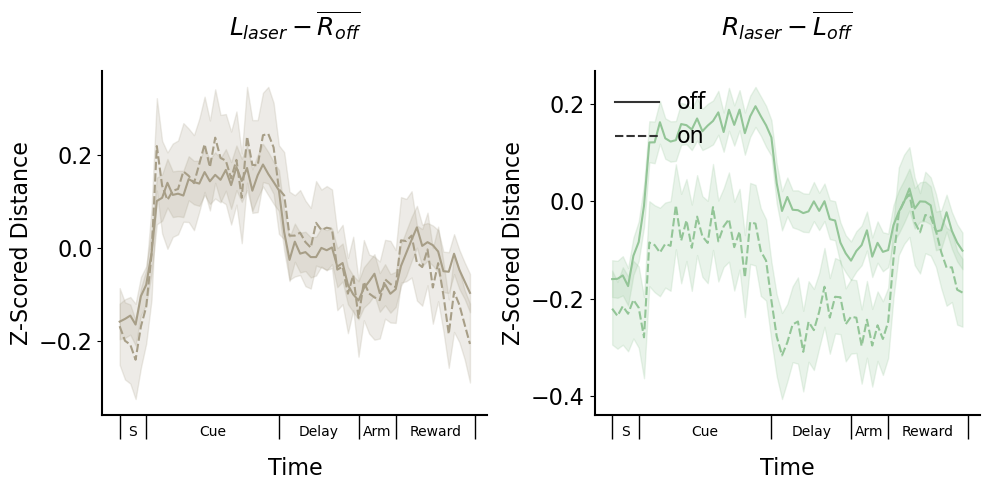

In [17]:
# select dpca type here:
pick = 2
with open(pickles[pick], 'rb') as handle:
    data = pickle.load(handle)

data_keys = ['roff_minus_loff_mean', 'ron_minus_loff_mean', 'loff_minus_roff_mean', 'lon_minus_roff_mean']
bin_sizes = [5, 25, 15, 7, 15]
bin_locs = np.cumsum(bin_sizes)

n_sessions = len(data[data_keys[0]])
labels = [r'$R_{off} - \overline{L_{off}}$', r'$R_{on} - \overline{L_{off}}$', r'$L_{off} - \overline{R_{off}}$', r'$L_{on} - \overline{R_{off}}$']
for i in range(n_sessions):
    
    if data[data_keys[0]][i].mean() < data[data_keys[2]][i].mean():
        data[data_keys[0]][i] = data[data_keys[0]][i] * -1
        data[data_keys[1]][i] = data[data_keys[1]][i] * -1
    else:
        data[data_keys[2]][i] = data[data_keys[2]][i] *-1
        data[data_keys[3]][i] = data[data_keys[3]][i] *-1
    all_dist = np.concatenate([data[key][i] for key in data_keys], axis=0)
    av = all_dist.mean()
    std = all_dist.std()
    for key in data_keys:
        data[key][i] = (data[key][i] - av)/std  # zscoring
    
df_all = pd.DataFrame()
left_right = ['right', 'right', 'left', 'left']
lsr = ['off', 'on', 'off', 'on']
for i, key in enumerate(data_keys):
    df = pd.DataFrame(np.concatenate([data[key][i] for i in range(n_sessions)], axis=0))
    df['left_right'] = left_right[i]
    df['laser'] = lsr[i]
    df_all = pd.concat((df_all, df), axis=0)

df_all = df_all.melt(id_vars=['left_right', 'laser'], value_name='Z-Scored Distance', var_name='time')


# plotting:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
titles = [r"$L_{laser} - \overline{R_{off}}$", r"$R_{laser} - \overline{L_{off}}$"]
for i, c in enumerate(["left", "right"]):
    sns.lineplot(
        data=df_all[df_all.left_right == c],
        x="time",
        y="Z-Scored Distance",
        hue="left_right",
        style="laser",
        palette=colors[i : i + 1],
        ax=axs[i],
    )
    trial_xticks(axs[i])
    sns.despine()
    axs[i].get_legend().remove()
    axs[i].set_title(titles[i], pad=25)

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(
    handles[3:],
    labels[3:],
    loc="upper left",
    frameon=False,
    ncol=1,
    bbox_to_anchor=(0, 1),
)
plt.tight_layout()
